In [67]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

In [68]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

from lpn_mrs.datasets import MRSDataset
from lpn_mrs.networks import LPN_cond

In [69]:
from sklearn.decomposition import PCA

In [70]:
# Visualize true distribution using PCA
true_dataset = MRSDataset(root='../data', split='train')
all_samples = np.array([true_dataset[i] for i in range(len(true_dataset))])

mean = np.mean(all_samples, axis=0)
centered_samples = all_samples - mean

pca = PCA(n_components=2)
true_proj = pca.fit_transform(centered_samples) 
pc_vector = pca.components_

print(true_proj.shape)
print(pc_vector.shape)

(500, 2)
(2, 512)


In [72]:
x = np.mean(np.array([true_dataset[i] for i in range(len(true_dataset))]), axis = 0)
n_samples = 2
# x = torch.tensor(x).unsqueeze(0).unsqueeze(1).repeat(n_samples,1,1)
x = torch.zeros_like(torch.tensor(x)).repeat(n_samples,1,1)

In [ ]:
kernel = 3
hidden = 30
sigma_min = 0.0
sigma_max = 0.1
noise_init = 0.1
noise_final = 0.01

In [74]:
model = LPN_cond(in_dim = 1, hidden_c=1, hidden=hidden, kernel=kernel, beta=10, alpha=1e-6)
model.load_state_dict(torch.load(f"../weights/lpn_cond_mrs_h_{hidden}_k_{kernel}_n_({sigma_min}_{sigma_max})/LPN_best.pt"))

<All keys matched successfully>

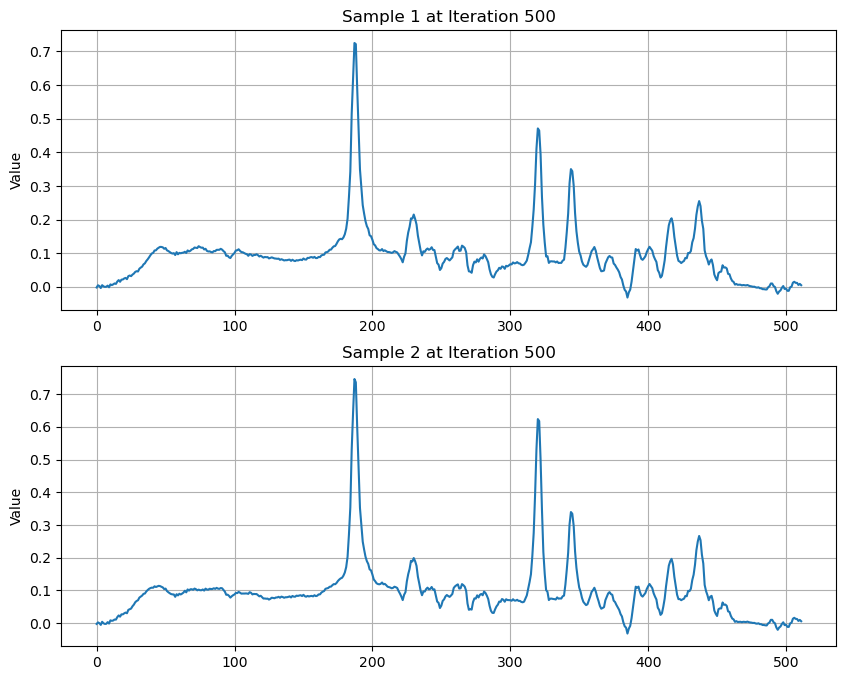

In [75]:
sample_projections = []

plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(n_samples, 1, figsize=(10, 8))

for it in range(500):
    # sigma = noise_init * (noise_final / noise_init) ** (it / 500)
    sigma = noise_init - (noise_init - noise_final) * (it / 500)
    noise_levels = torch.full((n_samples,1), sigma)
    x = model(x + torch.randn_like(x) * sigma * np.sqrt(2), noise_levels)

    current_sample = x.squeeze(1).detach().cpu().numpy()
    sample_proj = (current_sample - mean) @ pc_vector.T
    sample_projections.append(sample_proj)
    
    clear_output(wait=True)

    for i in range(n_samples):
        axs[i].cla()  # Clear axes
        axs[i].plot(x[i, 0].detach().numpy()) 
        axs[i].set_title(f'Sample {i + 1} at Iteration {it + 1}') 
        axs[i].set_ylabel('Value')
        axs[i].grid(True)

    display(fig)
    
    plt.pause(0.01)  # Wait for a brief moment to display the updated plots

# After the loop, keep the plot open
plt.ioff()  # Disable interactive mode
plt.show()

In [76]:
sample_projections = np.array(sample_projections)
print(sample_projections.shape)
length = sample_projections.shape[0]
colors = np.linspace(0, 1, length)

(500, 2, 2)


/tmp/ipykernel_3097409/515256522.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


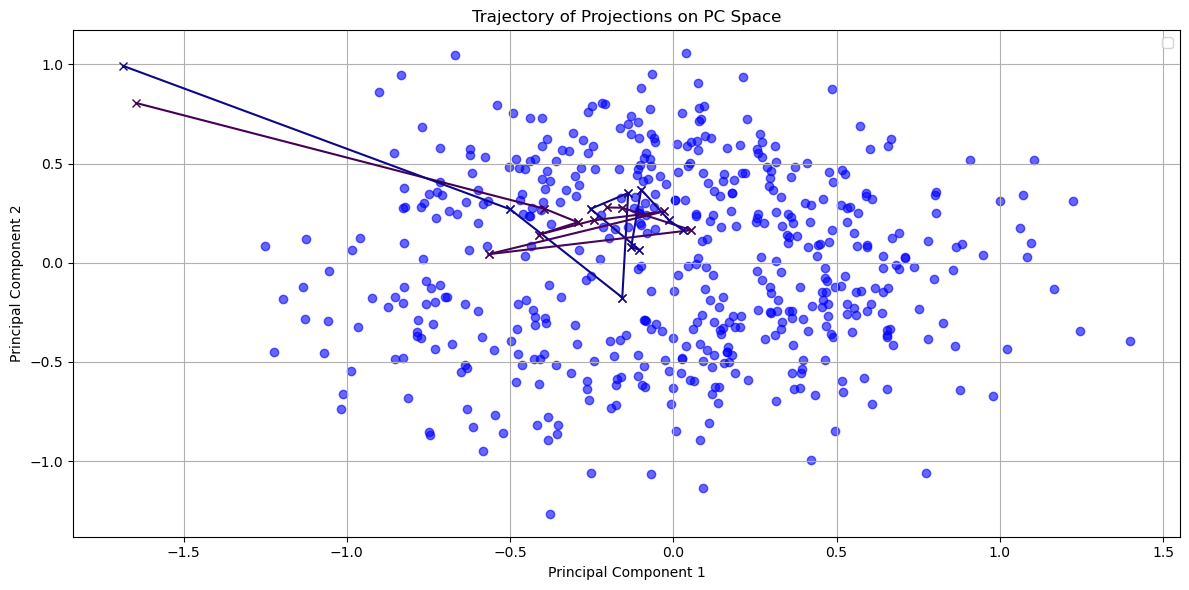

In [78]:
# Plot the trajectory of projections
plt.figure(figsize=(12, 6))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.6, color='blue')

stepsize = 50
for i in range(0, length-1, stepsize):
    plt.plot(sample_projections[i:(i + stepsize + 1):stepsize, 0, 0], sample_projections[i:(i + stepsize + 1):stepsize, 0, 1], marker='x', color=plt.cm.viridis(colors[int(i/stepsize)]))
    plt.plot(sample_projections[i:(i + stepsize + 1):stepsize, 1, 0], sample_projections[i:(i + stepsize + 1):stepsize, 1, 1], marker='x', color=plt.cm.plasma(colors[int(i/stepsize)]))

plt.title("Trajectory of Projections on PC Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()